In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
from collections import namedtuple
import numpy as np
import numpy.polynomial.polynomial as polynomial
import tensorflow as tf
random.seed(234921)

In [2]:
# make a polynomial with the given number of roots, but no root at 0
poly_degree = 7
poly_roots = list(np.arange(poly_degree + 1) - int(poly_degree/2))
poly_roots.remove(0)
poly_roots = np.array(poly_roots)
print "poly_roots: %s" % poly_roots
poly_coeffs = polynomial.polyfromroots(poly_roots)
print "poly_coeffs: %s" % poly_coeffs

poly_roots: [-3 -2 -1  1  2  3  4]
poly_coeffs: [ 144.  -36. -196.   49.   56.  -14.   -4.    1.]


In [3]:
deltax = .1
x_all = np.arange(poly_roots[0]-.2, poly_roots[-1]+.2, deltax)
y_all = polynomial.polyval(x_all, poly_coeffs)

number_points_to_train = 20
inds = range(len(x_all))
random.shuffle(inds)
x_train = x_all[inds[0:number_points_to_train]]
y_train = y_all[inds[0:number_points_to_train]]

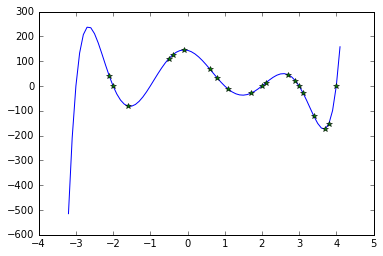

In [4]:
plt.plot(x_all,y_all)
plt.plot(x_train, y_train, '*');

In [5]:
# following https://www.tensorflow.org/versions/master/get_started/index.html
# we'll fit a linear model to this.

# I'm using a namedtuple because I was clobbering variable names with the polynomial data

linModel = namedtuple("TensorFlowModel", "W b y loss optimizer train")
linModel.W = tf.Variable(tf.random_uniform([1],-1.0, 1.0))
linModel.b = tf.Variable(tf.zeros([1]))
linModel.y = linModel.W * x_train + linModel.b  # cool how you can multple a tf variable against a numpy array


In [6]:
linModel.loss = tf.reduce_mean(tf.square(linModel.y - y_train))
# at first I did this with the learning rate of 0.5, but that is to big, I quickly got Nan's in the optimizaiton
linModel.optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.005)
linModel.train = linModel.optimizer.minimize(linModel.loss)

In [7]:
linModel.init = tf.initialize_all_variables()

In [8]:
linModel.sess = tf.Session()
linModel.sess.run(linModel.init)

In [9]:
for step in xrange(1001):
    linModel.sess.run(linModel.train)
    if step % 100 == 0:
        print "step=%d W=%.2f b=%.2f" % (step, linModel.sess.run(linModel.W), linModel.sess.run(linModel.b))

step=0 W=-0.18 b=-0.01
step=100 W=-16.12 b=11.94
step=200 W=-18.40 b=20.14
step=300 W=-19.62 b=24.59
step=400 W=-20.28 b=26.99
step=500 W=-20.64 b=28.29
step=600 W=-20.83 b=28.99
step=700 W=-20.93 b=29.37
step=800 W=-20.99 b=29.58
step=900 W=-21.02 b=29.69
step=1000 W=-21.04 b=29.75


In [10]:
linModel.W_result = linModel.sess.run(linModel.W)
linModel.b_result = linModel.sess.run(linModel.b)

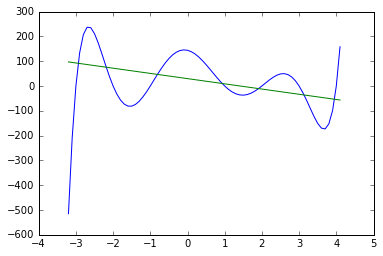

In [11]:
plt.plot(x_all, y_all)
plt.plot(x_all, linModel.W_result * x_all + linModel.b_result)

In [12]:
linModel.sess.close()
del linModel

## Nueral network

Let's build a two layer nueral network, where we use a bunch of nodes in the hidden layer. 
Theoretically, you can fit any function with enough nodes there. First we'll build up the model:

$$ H = \sigma(x \cdot W_h + B_h)$$
$$ O = H \cdot W_o + B_o$$

The terms will be as follows:
  
  * input: $x$, will be a  $20 \times 1$ matrix
  * $W_h$ will have shape: $1 \times N$ where $N$ is the number of nodes in the hidden layer
  * $B_h$ will have shape: $1 \times N$ 
  * $H$ will have shape: $20 \times N$
  * $W_o$ will have shape $N \times 1$
  * $B_o$ will have shape $1 \times 1$
  * Finally $O$ will have shape $20 \times 1$
  * and $\sigma$ will be the sigmoid function, whose range is (-1,1).

The loss function that we will optimize will be roughly

$$ L = \| O - y \|^2 + \lambda (\| W_h \|^2 + \|W_o \|^2) $$

Where 
* $\lambda$ will be the regularization term
* $\| A \|^2$ is the frobeniums norm, that is $\sum A_{ij}^2$

But maybe instead of frobenius, we'll use reduce_mean, so just divide by the number of terms there
  

In [36]:
nnModel = namedtuple("TensorFlowNNModel", "W_h B_h W_o B_o model loss optimizer train init sess")
number_nuerons_hidden_layer = 500
stddev = 3.0
nnModel.X = tf.placeholder("float32", [None,1])
nnModel.Y = tf.placeholder("float32", [None,1])
nnModel.W_h = tf.Variable(tf.random_normal((1, number_nuerons_hidden_layer), stddev=stddev))
nnModel.B_h = tf.Variable(tf.random_normal((1, number_nuerons_hidden_layer), stddev=stddev))
nnModel.W_o = tf.Variable(tf.random_normal((number_nuerons_hidden_layer,1), stddev=stddev))
nnModel.B_o = tf.Variable(tf.random_normal((1,1), stddev=stddev))
nnModel.regularization = 0.01

In [37]:
# build model
X_times_W_h = tf.matmul(nnModel.X, nnModel.W_h)
add_bias_h = tf.add(X_times_W_h, nnModel.B_h)
hidden_layer_res = tf.nn.sigmoid(add_bias_h)
hidden_times_W_o = tf.matmul(hidden_layer_res, nnModel.W_o)
nnModel.model = tf.add(hidden_times_W_o, nnModel.B_o)

nnModel.regularizationTerm = tf.mul(regularization, tf.reduce_sum(tf.mul(nnModel.W_h, nnModel.W_h)) + \
                                            tf.reduce_sum(tf.mul(nnModel.W_o, nnModel.W_o)))


In [38]:
nnModel.loss = tf.reduce_mean(tf.square(nnModel.model - nnModel.Y)) + \
               tf.mul(nnModel.regularization, tf.reduce_mean( nnModel.regularizationTerm))
nnModel.optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
nnModel.train = nnModel.optimizer.minimize(nnModel.loss)


In [39]:
nnModel.init = tf.initialize_all_variables()

In [40]:
nnModel.sess = tf.Session()
nnModel.sess.run(nnModel.init)

In [41]:
nn_X_train = np.resize(x_train, (len(x_train),1))
nn_Y_train = np.resize(y_train, (len(y_train),1))

for step in xrange(10001):
    nnModel.sess.run(nnModel.train, feed_dict={nnModel.X:nn_X_train, nnModel.Y:nn_Y_train})
    if step % 1000 == 0:
        print "step=%d loss=%.2f" % (step, nnModel.sess.run(nnModel.loss, feed_dict={nnModel.X:nn_X_train, nnModel.Y:nn_Y_train}))

step=0 loss=4277.23
step=1000 loss=2329.28
step=2000 loss=2628.47
step=3000 loss=2601.62
step=4000 loss=3029.23
step=5000 loss=2623.26
step=6000 loss=2134.00
step=7000 loss=1274.81
step=8000 loss=1220.01
step=9000 loss=1196.36
step=10000 loss=1180.47


In [42]:
nnModel.y_res = nnModel.sess.run(nnModel.model, feed_dict={nnModel.X:nn_X_train})
x_all_nn_shape = np.resize(x_all, (len(x_all), 1))
nnModel.y_all = nnModel.sess.run(nnModel.model, feed_dict={nnModel.X:x_all_nn_shape})



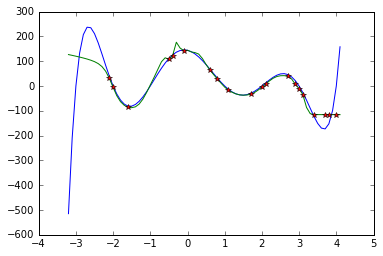

In [43]:
plt.plot(x_all, y_all)
plt.plot(x_all, nnModel.y_all)
plt.plot(x_train, nnModel.y_res[:,0], '*');

In [35]:
nnModel.sess.close()
del nnModel